In [33]:
%matplotlib inline
import numpy as np
from astropy.utils.data import download_file
from astropy.io import fits
import astropy.units as u
from specutils import Spectrum1D
import matplotlib.pyplot as plt
from json import load
from batman import TransitModel, TransitParams
from scipy.stats import binned_statistic


phoenix_model_temps = np.array([3200, 6400, 14500, 4100, 12500, 5000, 6700,
                                 10400, 2700, 11600, 3600, 7000, 7600, 4500,
                                 10600, 5400, 5700, 3100, 7400, 10000, 4000,
                                 6000, 4900, 8400, 7200, 2600, 6300, 15000,
                                 3500, 4400, 6600, 9600, 13500, 5300, 7800,
                                 3000, 6900, 9400, 3900, 12000, 4800, 5600,
                                 2500, 9200, 8800, 3400, 5900, 4300, 8000,
                                 9000, 5200, 6200, 9800, 2900, 13000, 3800,
                                 6500, 11400, 14000, 4700, 2400, 6800, 8600,
                                 3300, 4200, 5500, 11800, 5100, 11000, 10200,
                                 2800, 5800, 3700, 8200, 10800, 4600, 6100,
                                 2300, 11200])


def get_url(T_eff, log_g):
    closest_grid_temperature = phoenix_model_temps[np.argmin(np.abs(phoenix_model_temps - T_eff))]

    url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
           'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
           'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=closest_grid_temperature,
                                                    log_g=log_g)
    return url


def get_phoenix_model_spectrum(T_eff, log_g=4.5, cache=True):
    """
    Download a PHOENIX model atmosphere spectrum for a star with given
    properties.

    Parameters
    ----------
    T_eff : float
        Effective temperature. The nearest grid-temperature will be selected.
    log_g : float
        This must be a log g included in the grid for the effective temperature
        nearest ``T_eff``.
    cache : bool
        Cache the result to the local astropy cache. Default is `True`.

    Returns
    -------
    spectrum : `~specutils.Spectrum1D`
        Model spectrum
    """
    url = get_url(T_eff=T_eff, log_g=log_g)
    fluxes_path = download_file(url, cache=cache, timeout=30)
    fluxes = fits.getdata(fluxes_path)
    funit = u.Unit(fits.getheader(fluxes_path)['BUNIT'])

    wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                      'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
    wavelength_path = download_file(wavelength_url, cache=cache, timeout=30)
    wavelengths_vacuum = fits.getdata(wavelength_path)

    # Wavelengths are provided at vacuum wavelengths. For ground-based
    # observations convert this to wavelengths in air, as described in
    # Husser 2013, Eqns. 8-10:
    sigma_2 = (10**4 / wavelengths_vacuum)**2
    f = (1.0 + 0.05792105/(238.0185 - sigma_2) + 0.00167917 /
         (57.362 - sigma_2))
    wavelengths_air = wavelengths_vacuum / f

    spectrum = Spectrum1D(fluxes * funit, wavelengths_air * u.Angstrom)

    return spectrum


In [35]:
phot = get_phoenix_model_spectrum(4800)
spot = get_phoenix_model_spectrum(4500)

(0.0, 10000000000000.0)

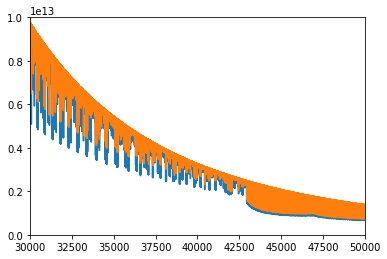

In [55]:
for m in [spot, phot]:
    plt.plot(m.wavelength, m.flux)
plt.xlim(([3, 5]*u.um).to(u.Angstrom).value)
plt.ylim(np.array([0, 1]) * 1e13)

In [57]:
p = TransitParams()

with open('hat11_parameters.json', 'r') as params: 
    paramdict = load(params)
    
    for param in paramdict:
        setattr(p, param, paramdict[param])

In [64]:
p.u = [0.132, 0.243]  # From ExoCTK for K band

In [65]:
times = np.linspace(p.t0 - p.duration, p.t0 + p.duration, 500)
transit_model = TransitModel(p, times).light_curve(p)

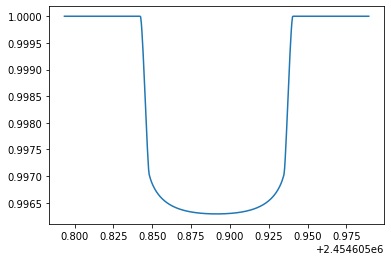

In [66]:
plt.plot(times, transit_model)

Fractional flux: 
$$ \frac{\Delta F}{F} = \frac{\pi R_\star^2 F_\mathrm{total} - \pi R_p^2 F_\mathrm{occulted}}{\pi R_\star^2 F_\mathrm{total}}$$
where
$$ F_\mathrm{total} = f_S F_\mathrm{spot} + (1 - f_S) F_\mathrm{phot}$$

In [159]:
f_S = np.array([0.01, 0.03, 0.1])[:, None]
f_occulted = phot.flux
f_total = (1-f_S) * phot.flux + f_S * spot.flux

In [184]:
from astropy.io import fits
wl, d, e, md = fits.getdata('ed_eq_m_1_t_840_norm.dat.fits')

bins = np.linspace(3, 5, 28)

bincenters = 0.5 * (bins[1:] + bins[:-1])

depth =  1 - (1 - p.rp**2 * (f_occulted / f_total)) / (1 - p.rp**2)

depth_binned = binned_statistic(phot.wavelength.to(u.um).value, 
                                depth, bins=bins, 
                                statistic=lambda x: x.mean(axis=0)).statistic

binned_errorbars = binned_statistic(wl, d, 
                                    bins=bins, 
                                    statistic=lambda x: e[np.in1d(d, x)].mean() / np.count_nonzero(x)**0.5).statistic

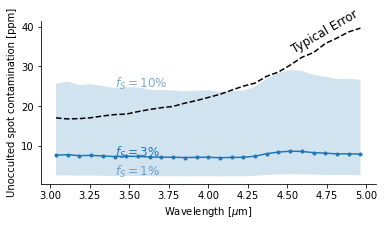

In [215]:
plt.figure(figsize=(6, 3))
ax = plt.gca()
ax.fill_between(bincenters, *depth_binned[[0, 2]] * 1e6, alpha=0.2)
ax.plot(bincenters, depth_binned[1] * 1e6, '.-', color='C0')
ax.set(xlabel='Wavelength [$\mu$m]', 
       ylabel='Unocculted spot contamination [ppm]')

fs = 12
ax.annotate("$f_S = 1\%$", 
            (bincenters[5], 1e6 * 1.01 * depth_binned[0, 5]), 
            xycoords='data', fontsize=fs, 
            color='C0', alpha=0.6)
ax.annotate("$f_S = 3\%$", 
            (bincenters[5], 1e6 * 1.01 * depth_binned[1, 5]), 
            xycoords='data', fontsize=fs, 
            color='C0')
ax.annotate("$f_S = 10\%$", 
            (bincenters[5], 1e6 * 1.01 * depth_binned[2, 5]), 
            xycoords='data', fontsize=fs,
            color='C0', alpha=0.6)

ax.plot(bincenters, 1e6 * binned_errorbars, color='k', ls='--')
ax.annotate("Typical Error", (bincenters[-1], 1e6 * binned_errorbars[-1] - 6), 
            xycoords='data', ha='right', fontsize=fs, rotation=30)
for sp in ['right', 'top']:
    ax.spines[sp].set_visible(False)
plt.savefig('contamination.pdf', bbox_inches='tight')
# plt.savefig('contamination.png', bbox_inches='tight')

In [207]:
bincenters[0] / (bincenters[1] - bincenters[0])

41.00000000000031

In [124]:
# plt.plot(transit_model[:, None] * (1 + depth_binned));